In [1]:
import torch,gc, os
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_ar_ap, get_eval_params_dict
from utils.transforms import get_transform
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.plot import  plot_result, plot_loss, get_legend_elements, plot_evaluator, disease_cmap
from utils.save import save_model

from data.dataset import ReflacxDataset, collate_fn
from models.load import ModelSetup, create_model_from_setup
from copy import deepcopy

from datetime import datetime
from IPython.display import clear_output

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device.upper()}]")

if use_gpu:
    torch.cuda.empty_cache()

This notebook will running on device: [CUDA]


In [4]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"

# all_model_setups = [
#     ModelSetup(
#         name="original",
#         use_clinical=False,
#         use_custom_model=False,
#         use_early_stop_model=True,
#     ),
#     ModelSetup(
#         name="custom_without_clinical",
#         use_clinical=False,
#         use_custom_model=True,
#         use_early_stop_model=True,
#     ),
#     ModelSetup(
#         name="custom_with_clinical",
#         use_clinical=True,
#         use_custom_model=True,
#         use_early_stop_model=True,
#     ),
# ]

## train for 20 epoch first.
all_model_setups = [
    ModelSetup(
        name="original",
        use_clinical=False,
        use_custom_model=False,
        use_early_stop_model=True,
    ),
    ModelSetup(
        name="custom_without_clinical",
        use_clinical=False,
        use_custom_model=True,
        use_early_stop_model=True,
    ),
    ModelSetup(
        name="custom_with_clinical",
        use_clinical=True,
        use_custom_model=True,
        use_early_stop_model=True,
    ),
]

In [5]:
model_setup = all_model_setups[1]

In [6]:
clinical_cond = "With" if model_setup.use_clinical else "Without"

In [7]:
legend_elements = get_legend_elements(disease_cmap["solid"])

In [8]:
labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": model_setup.use_clinical,
    "dataset_mode": "unified",
    "bbox_to_mask": True,
    "labels_cols": labels_cols,
}

detect_eval_dataset = ReflacxDataset(
    **{**dataset_params_dict, "dataset_mode": "unified",},
    transforms=get_transform(train=False),
)

train_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="train", transforms=get_transform(train=True),
)

val_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="val", transforms=get_transform(train=False),
)

test_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="test", transforms=get_transform(train=False),
)

batch_size = 4

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)


In [8]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.5569, 0.5608, 0.5608],
          [0.0000, 0.0000, 0.0000,  ..., 0.5647, 0.5647, 0.5569],
          [0.0000, 0.0000, 0.0000,  ..., 0.5608, 0.5569, 0.5490],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7686, 0.7686],
          [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7647, 0.7608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7569, 0.7569, 0.7529]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.5569, 0.5608, 0.5608],
          [0.0000, 0.0000, 0.0000,  ..., 0.5647, 0.5647, 0.5569],
          [0.0000, 0.0000, 0.0000,  ..., 0.5608, 0.5569, 0.5490],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7686, 0.7686],
          [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7647, 0.7608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7569, 0.7569, 0.7529]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.5569, 0.5608, 0.5608],
          [0.0000, 0.0000, 0.0000,  ..., 0.5647, 0.5647, 0.5569],
          [0.0000, 0.0000, 0.0000,  ...,

In [9]:
model = create_model_from_setup(detect_eval_dataset, model_setup, device)

{'rpn_nms_thresh': 0.3, 'box_detections_per_img': 6, 'box_nms_thresh': 0.2, 'rpn_score_thresh': 0.0, 'box_score_thresh': 0.05}
c1
None


In [10]:
print(f"Model size: {sum([param.nelement()  for param in model.parameters()]):,}")

Model size: 43,943,923


In [11]:
params = [p for p in model.parameters() if p.requires_grad]
lr_scheduler = None

# construct an optimizer

# optimizer = torch.optim.Adam(params, lr=0.05 ,weight_decay=0.0005)
# lr_scheduler = None
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

## Original Setting (Kinda work)

# and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [12]:
# eval_params_dict = get_eval_params_dict(detect_eval_dataset, )

# iou_thrs = np.array([0.00, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
#        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.])

eval_params_dict = get_eval_params_dict(
    detect_eval_dataset,
    #  iou_thrs=iou_thrs,
    use_iobb=use_iobb,
)



creating index...
index created!


In [13]:

num_epochs = 100

## intialise training recorders.
train_logers = []
val_evaluators = []
test_evaluator = None

## Setup the patience for learninig rate scheduler (if use_early_stop)
best_val_ar = 0
max_patience = 20
current_patience = 0

best_val_model_path = None

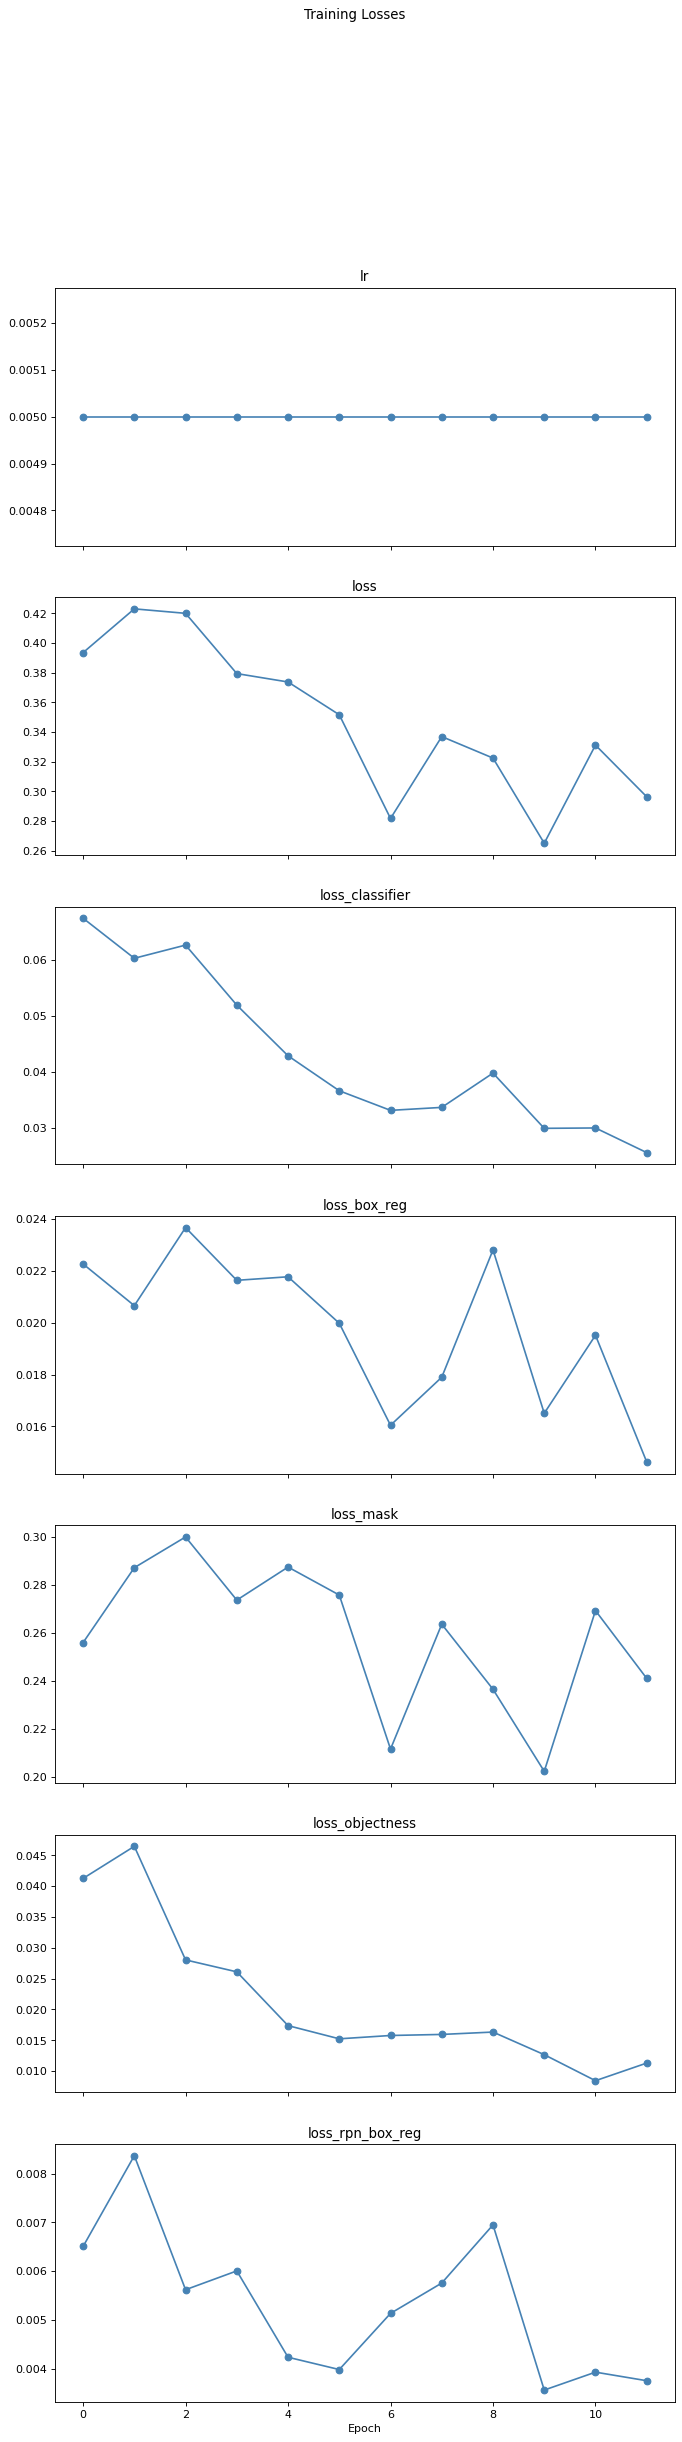

creating index...
index created!
Test:  [ 0/22]  eta: 0:00:32  model_time: 0.2826 (0.2826)  evaluator_time: 0.4192 (0.4192)  time: 1.4899  data: 0.5120  max mem: 2237
Test:  [21/22]  eta: 0:00:01  model_time: 0.1770 (0.1801)  evaluator_time: 0.3191 (0.3222)  time: 1.0979  data: 0.5174  max mem: 2237
Test: Total time: 0:00:24 (1.1090 s / it)
Averaged stats: model_time: 0.1770 (0.1801)  evaluator_time: 0.3191 (0.3222)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ] = 0.237
 Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ] = 0.137
 Average Precision  (AP) @[ IoBB=0.50:0.95 | area= small | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.50:0.95 | area=medium | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.50:0.95 | area= lar

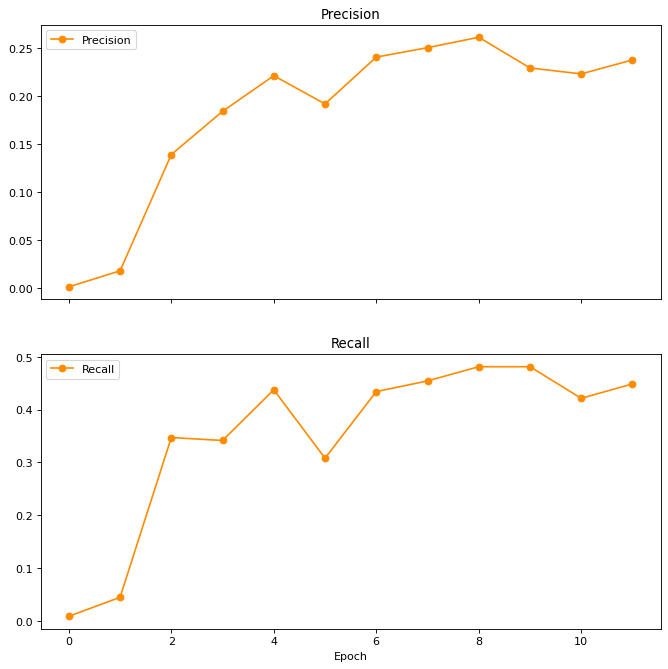

Epoch: [13]  [  0/104]  eta: 0:01:22  lr: 0.005000  loss: 0.3142 (0.3142)  loss_classifier: 0.0315 (0.0315)  loss_box_reg: 0.0110 (0.0110)  loss_mask: 0.2605 (0.2605)  loss_objectness: 0.0090 (0.0090)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 0.7897  data: 0.5181  max mem: 2237
Epoch: [13]  [ 10/104]  eta: 0:01:17  lr: 0.005000  loss: 0.3193 (0.3190)  loss_classifier: 0.0236 (0.0237)  loss_box_reg: 0.0149 (0.0172)  loss_mask: 0.2631 (0.2671)  loss_objectness: 0.0062 (0.0063)  loss_rpn_box_reg: 0.0025 (0.0047)  time: 0.8239  data: 0.5496  max mem: 2237
Epoch: [13]  [ 20/104]  eta: 0:01:09  lr: 0.005000  loss: 0.3088 (0.3110)  loss_classifier: 0.0176 (0.0214)  loss_box_reg: 0.0133 (0.0158)  loss_mask: 0.2621 (0.2640)  loss_objectness: 0.0057 (0.0060)  loss_rpn_box_reg: 0.0025 (0.0038)  time: 0.8261  data: 0.5495  max mem: 2237
Epoch: [13]  [ 30/104]  eta: 0:01:01  lr: 0.005000  loss: 0.3088 (0.3168)  loss_classifier: 0.0178 (0.0232)  loss_box_reg: 0.0144 (0.0165)  loss_mask: 0.2621 (0.26

KeyboardInterrupt: 

In [ ]:
# 50 epoch
# val_ar_0_2370_ap_0_1530_test_ar_0_2396_ap_0_1236_epoch50_WithoutClincal_03-27-2022 02-41-12 (original)
# val_ar_0_2658_ap_0_1993_test_ar_0_2717_ap_0_1816_epoch50_WithoutClincal_03-27-2022 04-56-32(custom without clinical)
# val_ar_0_3839_ap_0_2107_test_ar_0_5359_ap_0_2286_epoch50_WithClincal_03-27-2022 06-59-57 (custom with clinical)


# early_stop (on AR)
## Original

## Custom without clinical

## Custom with clinical
# val_ar_0_4986_ap_0_2911_test_ar_0_5360_ap_0_2273_epoch35_WithClincal_03-27-2022 16-00-27 (best)
# val_ar_0_1551_ap_0_1462_test_ar_0_2225_ap_0_1449_epoch100_WithClincal_03-27-2022 18-23-42(final)

# early_stop (on AP)



# Try larger dropout (.3)



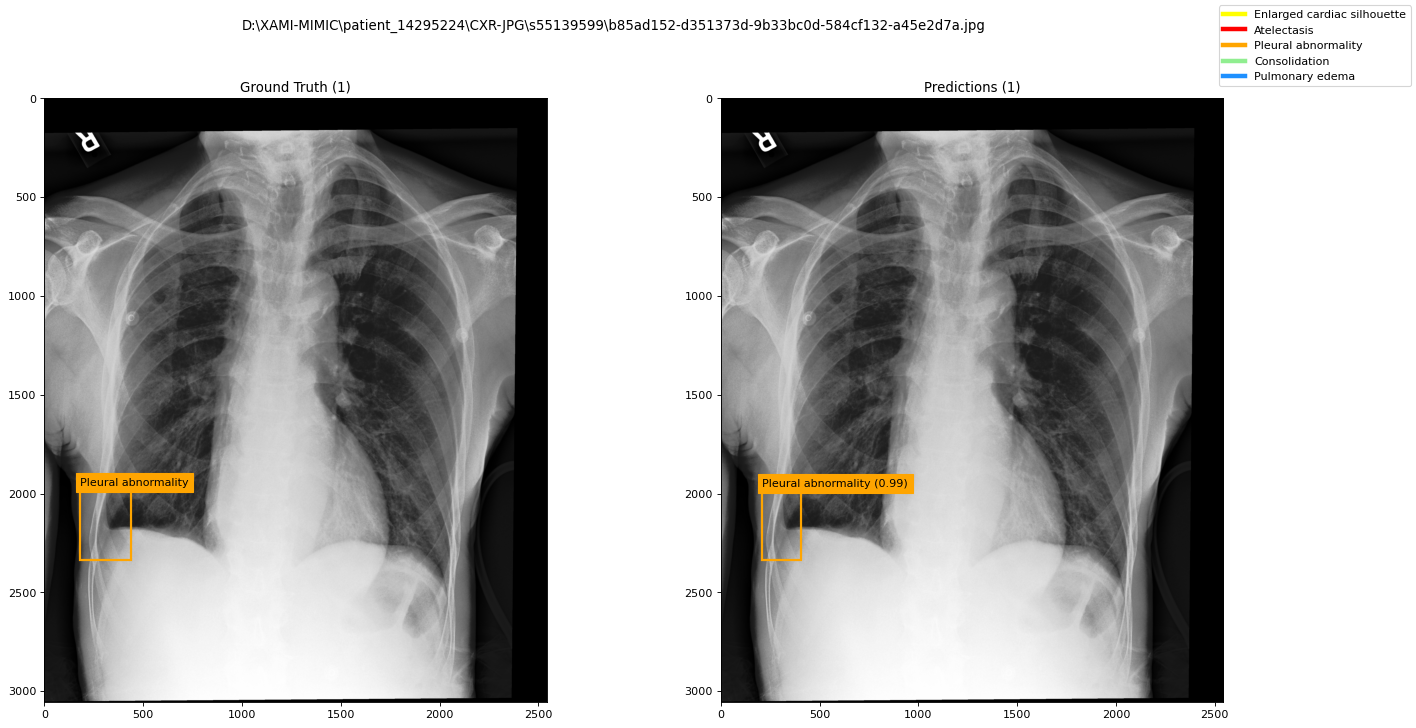

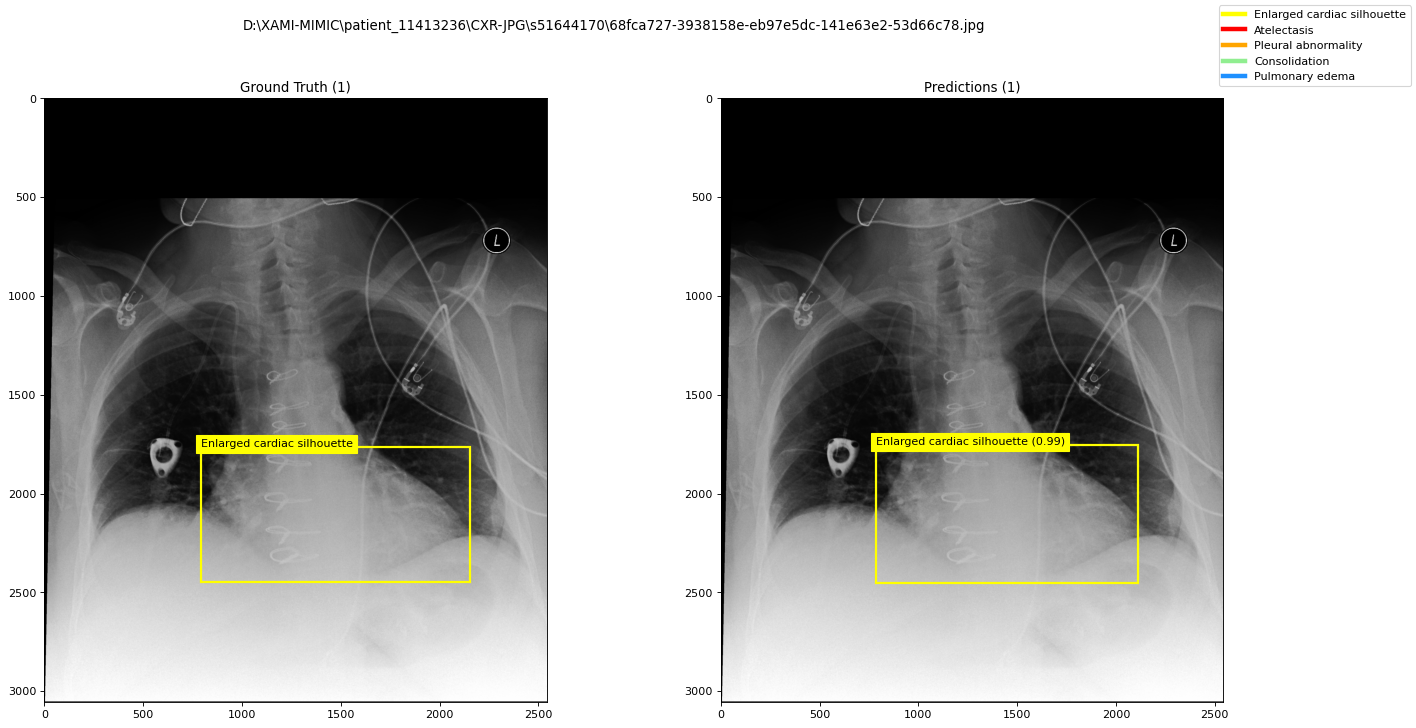

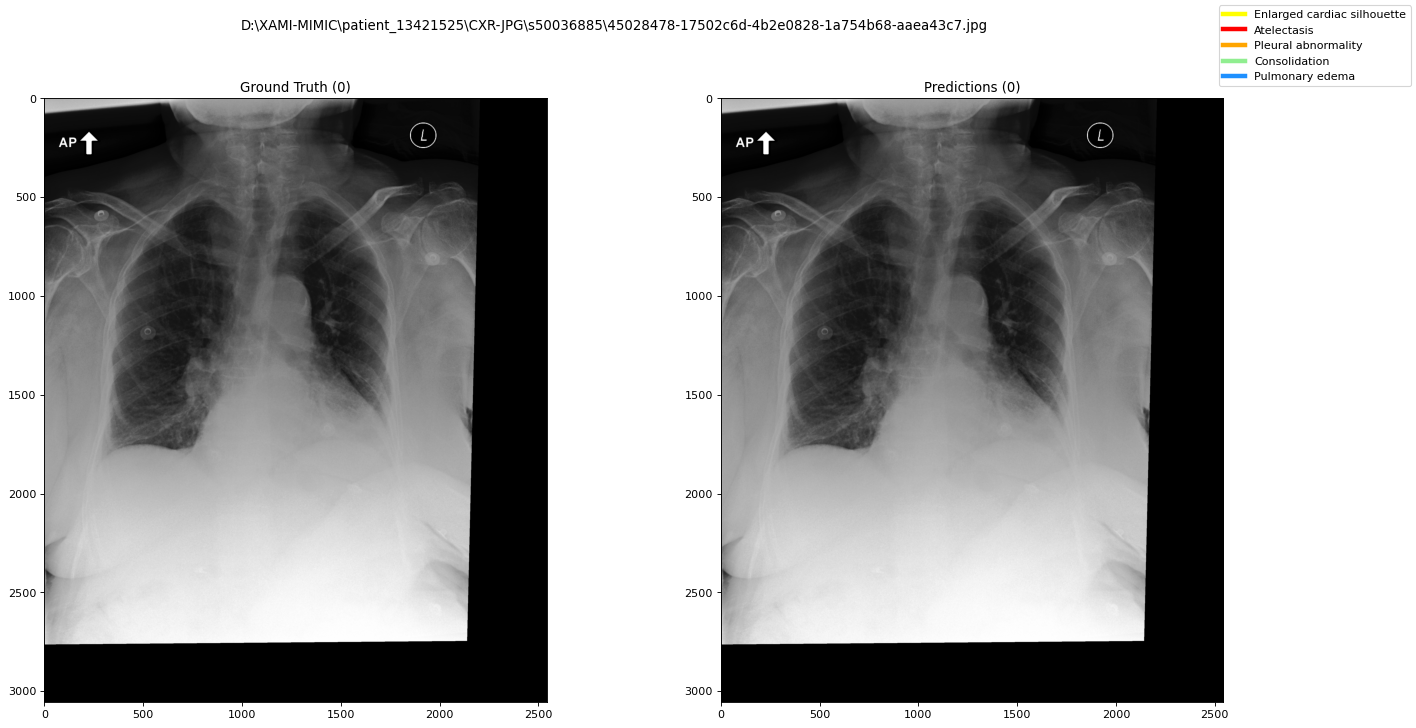

In [ ]:
# model.roi_heads.score_thresh = 0.3
# for i in [250, 99, 199]:
#     plot_result(
#         model=model,
#         dataset=detect_eval_dataset,
#         device=device,
#         idx= i,
#         legend_elements= legend_elements,
#         disease_cmap =disease_cmap,
#         seg=False,
#         seg_thres=0.5,
#     )

In [ ]:
# chekcing if a part of the model is being trained.
# for sector in [model.clinical_convs, model.fuse_convs]:
#     print(
#         sum(
#             [
#                 sum([p.grad.abs().sum() for p in model.clinical_convs[k].parameters()])
#                 for k in sector.keys()
#             ]
#         )
#     )

In [ ]:
# test_evaluator.summarize()

In [ ]:
# eval_params_dict = get_eval_params_dict(detect_eval_dataset)
# params_test_evaluator = xami_evaluate(model, test_dataloader, device=device, params_dict=eval_params_dict)
# params_test_evaluator.summarize()

In [ ]:
# _ = external_summarize(
#     params_test_evaluator.coco_eval["bbox"],
#     ap=1,
#     iouThr=0.5,
#     areaRng="all",
#     maxDets=6,
#     print_result=True,
# )
# _ = external_summarize(
#     params_test_evaluator.coco_eval["bbox"],
#     ap=0,
#     iouThr=0.5,
#     areaRng="all",
#     maxDets=6,
#     print_result=True,
# )

In [ ]:
# current_time_string = datetime.now().strftime("%m-%d-%Y %H-%M-%S")
# final_model_path =  f"epoch{epoch}_{clinial_cond}Clincal_{current_time_string}".replace(":", "_").replace(".", "_")

In [ ]:
# torch.save(model.state_dict(), os.path.join(
#     os.path.join('trained_models', final_model_path)
# ))

# print(f"Model has been saved: {final_model_path}")

In [ ]:
# training_record = OrderedDict({
#     "train_data": [ get_train_data(loger) for loger in train_logers],
#     "val_evaluators" : val_evaluators,
#     "test_evaluator": test_evaluator,
# })

# with open(
#     os.path.join("training_records", f"{final_model_path}.pkl"), "wb",
# ) as training_record_f:
#     pickle.dump(training_record, training_record_f)

In [ ]:
# epoch99_WithoutClincal_03-11-2022 09-05-17  (custom)
# epoch99_WithClincal_03-11-2022 17-34-14 (custom)
# epoch99_WithoutClincal_03-12-2022 07-56-08 (original)

In [ ]:
## 20 epoch each.
# val_ar_0_2536_ap_0_1206_test_ar_0_2864_ap_0_1256_epoch20_WithoutClincal_03-13-2022 23-20-30 (original)
# val_ar_0_3397_ap_0_1889_test_ar_0_3146_ap_0_1402_epoch20_WithoutClincal_03-14-2022 00-30-30 (custom)
# val_ar_0_3212_ap_0_1481_test_ar_0_2996_ap_0_1704_epoch20_WithClincal_03-14-2022 01-45-59 (custom)

In [ ]:
## Eearly stopiing (20 patience)
# val_ar_0_3000_ap_0_1542_test_ar_0_3504_ap_0_1386_epoch15_WithoutClincal_03-14-2022 03-10-11 (original)
# val_ar_0_3410_ap_0_1753_test_ar_0_3553_ap_0_1832_epoch33_WithoutClincal_03-14-2022 19-10-27(custom)
# val_ar_0_3909_ap_0_1828_test_ar_0_3808_ap_0_1542_epoch39_WithClincal_03-14-2022 17-14-52(custom)